In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
rosenberg = pd.read_parquet('GSE110823/GSM3017261_3K_random_counts.parquet')

In [5]:
%load_ext autoreload
%autoreload 2
import scVI
import tensorflow as tf
from helper import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from sklearn.model_selection import train_test_split

In [15]:
expression_train, expression_test = train_test_split(rosenberg.values)

In [53]:
expression_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

In [17]:
batch_size = 128
learning_rate = 0.001
epsilon = 0.01

In [52]:
log_library_size

array([5.92692603, 7.73368357, 6.7178047 , ..., 7.40610338, 6.7787849 ,
       6.84906628])

In [18]:
tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

# getting priors
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

# loading data
model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                         optimize_algo=optimizer, phase=training_phase, \
                          library_size_mean=mean, library_size_var=var)

#starting computing session
sess = tf.Session()

Running scVI on 26894 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space


In [19]:
# start a new graph and fit the training set

sess.run(tf.global_variables_initializer())
result = train_model(model, (expression_train, expression_test), sess, 250)

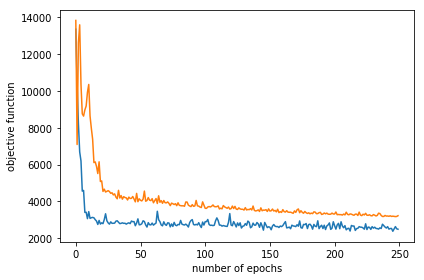

In [20]:
plot_training_info(result)

In [35]:
dic_full = {expression: rosenberg.values, training_phase:False}
latent = sess.run(model.z, feed_dict=dic_full)

In [36]:
latent.shape

(3000, 10)

In [37]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1)

In [38]:
YY = tsne.fit_transform(latent)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.002s...
[t-SNE] Computed neighbors for 3000 samples in 0.221s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.842918
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.172569
[t-SNE] Error after 1000 iterations: 1.270400


In [39]:
si = pd.read_parquet('GSE110823/GSM3017261_3K_random_sample_info.parquet')

In [40]:
si['TSNE_1'] = YY[:, 0]
si['TSNE_2'] = YY[:, 1]

In [41]:
YY.shape

(3000, 2)

In [44]:
import plotnine as p

In [49]:
si['simple_cluster'] = si.cluster_assignment.str.split(' ').str.get(1)

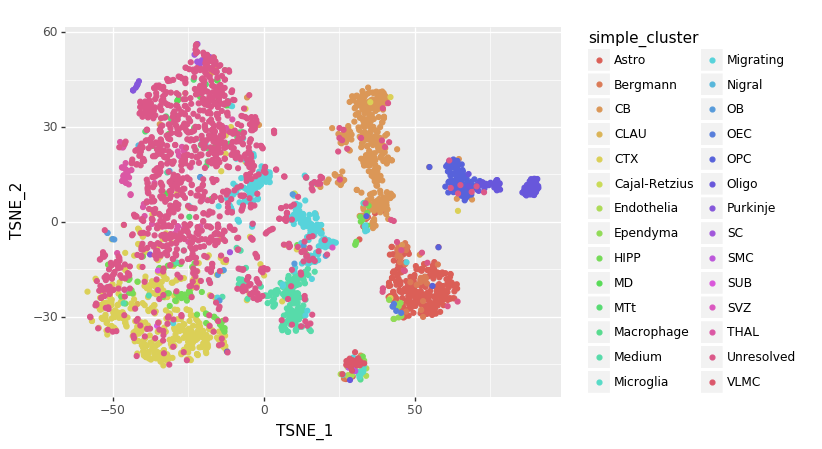

<ggplot: (-9223372036465374478)>

In [51]:
p.qplot('TSNE_1', 'TSNE_2', si, color='simple_cluster')

In [56]:
si[['TSNE_1', 'TSNE_2', 'cluster_assignment']].to_csv('scVI_Rosenberg_results.csv')

In [57]:
ls

DCA on Lukassen.ipynb           benchmarking.py
DCA on Rosenberg.ipynb          helper.py
DCA on Zeisel.ipynb             l6_r3_spinal_cord_neurons.loom
DCA_Rosenberg_results.csv       scVI on Lukassen.ipynb
GSE104556/                      scVI on Rosenberg.ipynb
GSE110823/                      scVI.py
Subsample Rosenberg.ipynb       scVI_Rosenberg_results.csv
__pycache__/
